### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

# warnings.filterwarnings("ignore")
# sys.path.append("/content/drive/MyDrive/graphs/TMD-master/") 


In [1]:
from torch_geometric.datasets import TUDataset
# from tmd import TMD
import networkx as nx
from torch_geometric.utils.convert import to_networkx,from_networkx


C:\Users\ekima\anaconda3\envs\graphs\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import matplotlib.pyplot as plt
import numpy as np
import torch
import ot
import copy
import seaborn as sns
from torch_geometric.data.data import Data

## Useful functions

In [3]:
def draw_graph(data):
    coragraph = to_networkx(data)
    nx.draw(coragraph, 
          cmap=plt.get_cmap('Set1'),
          node_size=120,
          linewidths=6, 
          with_labels=True, 
          node_color='red') 
    plt.show()  

    
def get_distrib(d1):
    adj = get_neighbors(d1)
    lens1 = []
    for v in adj.values():
        lens1.append(len(v))  
    return lens1

def plot_distr_plot(d1):
    fig = plt.figure("Degree of a graph", figsize=(6, 4))
    ax2 = fig.add_subplot()
    ax2.bar(*np.unique(get_distrib(d1), return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")
    fig.tight_layout()
    plt.show()

In [4]:
"""
Tree Mover's Distance solver
"""
# Author: Ching-Yao Chuang <cychuang@mit.edu>
# License: MIT License

import numpy as np
import torch
import ot
import copy


def get_neighbors(g):
    '''
    get neighbor indexes for each node

    Parameters
    ----------
    g : input torch_geometric graph


    Returns
    ----------
    adj: a dictionary that store the neighbor indexes

    '''
    adj = {}
    for i in range(len(g.edge_index[0])):
        node1 = g.edge_index[0][i].item()
        node2 = g.edge_index[1][i].item()
        if node1 in adj.keys():
            adj[node1].append(node2)
        else:
            adj[node1] = [node2]
    return adj


def TMD(g1, g2, w, L=4):
    '''
    return the Tree Mover’s Distance (TMD) between g1 and g2

    Parameters
    ----------
    g1, g2 : two torch_geometric graphs
    w : weighting constant for each depth
         if it is a list, then w[l] is the weight for depth-(l+1) tree
         if it is a constant, then every layer shares the same weight
    L    : Depth of computation trees for calculating TMD

    Returns
    ----------
    wass : The TMD between g1 and g2

    Reference
    ----------
    Chuang et al., Tree Mover’s Distance: Bridging Graph Metrics and
    Stability of Graph Neural Networks, NeurIPS 2022
    '''

    if isinstance(w, list):
        assert(len(w) == L-1)
    else:
        w = [w] * (L-1)

    # get attributes
    n1, n2 = len(g1.x), len(g2.x)
    # feat1, feat2 = g1.x, g2.x
    adj1 = get_neighbors(g1)
    adj2 = get_neighbors(g2)
    # no features 
    feat1 = torch.ones(n1,1)
    feat2 = torch.ones(n2,1)

    blank = np.zeros(len(feat1[0]))
    D = np.zeros((n1, n2))

    # level 1 (pair wise distance)
    M = np.zeros((n1+1, n2+1))
    for i in range(n1):
        for j in range(n2):
            D[i, j] = torch.norm(feat1[i] - feat2[j])
            M[i, j] = D[i, j]
    # distance w.r.t. blank node
    M[:n1, n2] = torch.norm(feat1, dim=1)
    M[n1, :n2] = torch.norm(feat2, dim=1)

    # level l (tree OT)
    for l in range(L-1):
        M1 = copy.deepcopy(M)
        M = np.zeros((n1+1, n2+1))

        # calculate pairwise cost between tree i and tree j
        for i in range(n1):
            for j in range(n2):
                try:
                    degree_i = len(adj1[i])
                except:
                    degree_i = 0
                try:
                    degree_j = len(adj2[j])
                except:
                    degree_j = 0

                if degree_i == 0 and degree_j == 0:
                    M[i, j] = D[i, j]
                # if degree of node is zero, calculate TD w.r.t. blank node
                elif degree_i == 0:
                    wass = 0.
                    for jj in range(degree_j):
                        wass += M1[n1, adj2[j][jj]]
                    M[i, j] = D[i, j] + w * wass
                elif degree_j == 0:
                    wass = 0.
                    for ii in range(degree_i):
                        wass += M1[adj1[i][ii], n2]
                    M[i, j] = D[i, j] + w * wass
                # otherwise, calculate the tree distance
                else:
                    max_degree = max(degree_i, degree_j)
                    if degree_i < max_degree:
                        cost = np.zeros((degree_i + 1, degree_j))
                        cost[degree_i] = M1[n1, adj2[j]]
                        dist_1, dist_2 = np.ones(degree_i + 1), np.ones(degree_j)
                        dist_1[degree_i] = max_degree - float(degree_i)
                    else:
                        cost = np.zeros((degree_i, degree_j + 1))
                        cost[:, degree_j] = M1[adj1[i], n2]
                        dist_1, dist_2 = np.ones(degree_i), np.ones(degree_j + 1)
                        dist_2[degree_j] = max_degree - float(degree_j)
                    for ii in range(degree_i):
                        for jj in range(degree_j):
                            cost[ii, jj] =  M1[adj1[i][ii], adj2[j][jj]]
                    wass = ot.emd2(dist_1, dist_2, cost)

                    # summarize TMD at level l
                    M[i, j] = D[i, j] + w[l] * wass

        # fill in dist w.r.t. blank node
        for i in range(n1):
            try:
                degree_i = len(adj1[i])
            except:
                degree_i = 0

            if degree_i == 0:
                M[i, n2] = torch.norm(feat1[i])
            else:
                wass = 0.
                for ii in range(degree_i):
                    wass += M1[adj1[i][ii], n2]
                M[i, n2] = torch.norm(feat1[i]) + w[l] * wass

        for j in range(n2):
            try:
                degree_j = len(adj2[j])
            except:
                degree_j = 0
            if degree_j == 0:
                M[n1, j] = torch.norm(feat2[j])
            else:
                wass = 0.
                for jj in range(degree_j):
                    wass += M1[n1, adj2[j][jj]]
                M[n1, j] = torch.norm(feat2[j]) + w[l] * wass


    # final OT cost
    max_n = max(n1, n2)
    dist_1, dist_2 = np.ones(n1+1), np.ones(n2+1)
    if n1 < max_n:
        dist_1[n1] = max_n - float(n1)
        dist_2[n2] = 0.
    else:
        dist_1[n1] = 0.
        dist_2[n2] = max_n - float(n2)

    wass = ot.emd2(dist_1, dist_2, M)
    return dist_1, dist_2, M, wass

In [5]:
def calculate_and_plot(d1, d2, l):
    dist_1, dist_2, M, wass = TMD(d1, d2, 1, L=l)
    path, d = ot.emd(dist_1, dist_2, M, log=True) 


    f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=False, num=1, figsize=(28, 8))
    sns.heatmap(M, annot=True, ax = ax1)
    ax1.set_title('Cost Matrix')
    sns.heatmap(path, annot=True, ax = ax2)
    ax2.set_title('Optimal Path')
    sns.heatmap(path * M, annot=True, ax = ax3)
    ax3.set_title('Cost Matrix * Optimal Path')
    print('Layer = ', l)
    print('Tree mover\'s distance = ', wass)

## Small Sample 

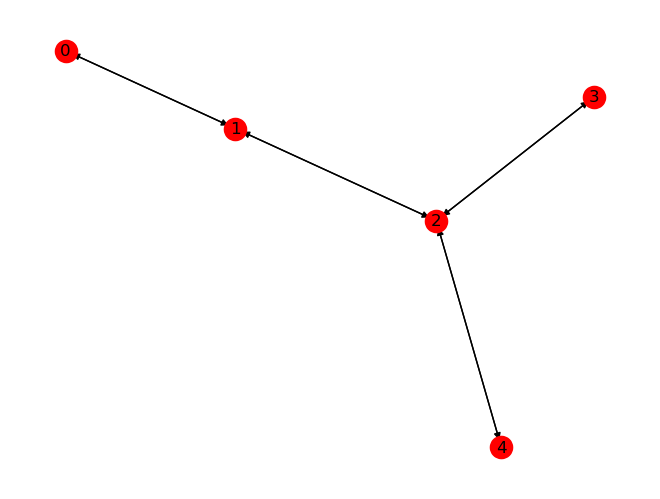

In [30]:
## Graph 1 ## 
edge_index = torch.tensor([[0, 1, 1, 2, 2, 2, 3, 4],
                           [1, 2, 0, 3, 4, 1, 2, 2]], dtype=torch.long)
x = torch.tensor([[1], [1], [1], [1], [1]], dtype=torch.float)
d1 = Data(x=x, edge_index=edge_index)
draw_graph(d1)

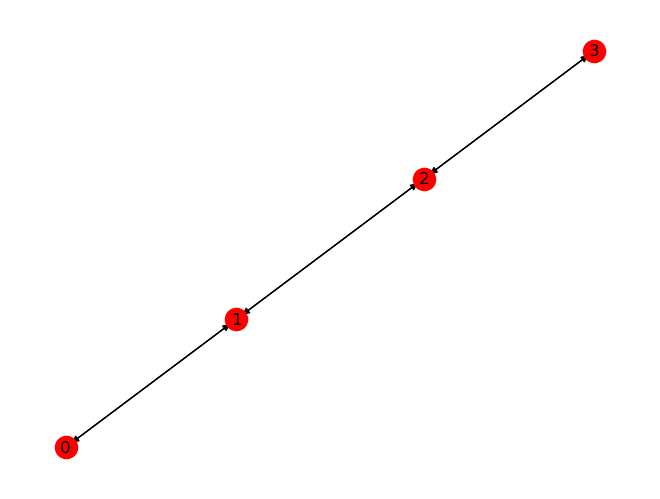

In [31]:
## Graph 2 ## 
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3],
                           [1, 2, 0, 1, 3, 2]], dtype=torch.long)
x = torch.tensor([[1], [1], [1], [1]], dtype=torch.float)
d2 = Data(x=x, edge_index=edge_index)
draw_graph(d2)

In [1]:
calculate_and_plot(d1, d2, 2)

NameError: name 'calculate_and_plot' is not defined

Layer =  3
Tree mover's distance =  9.0


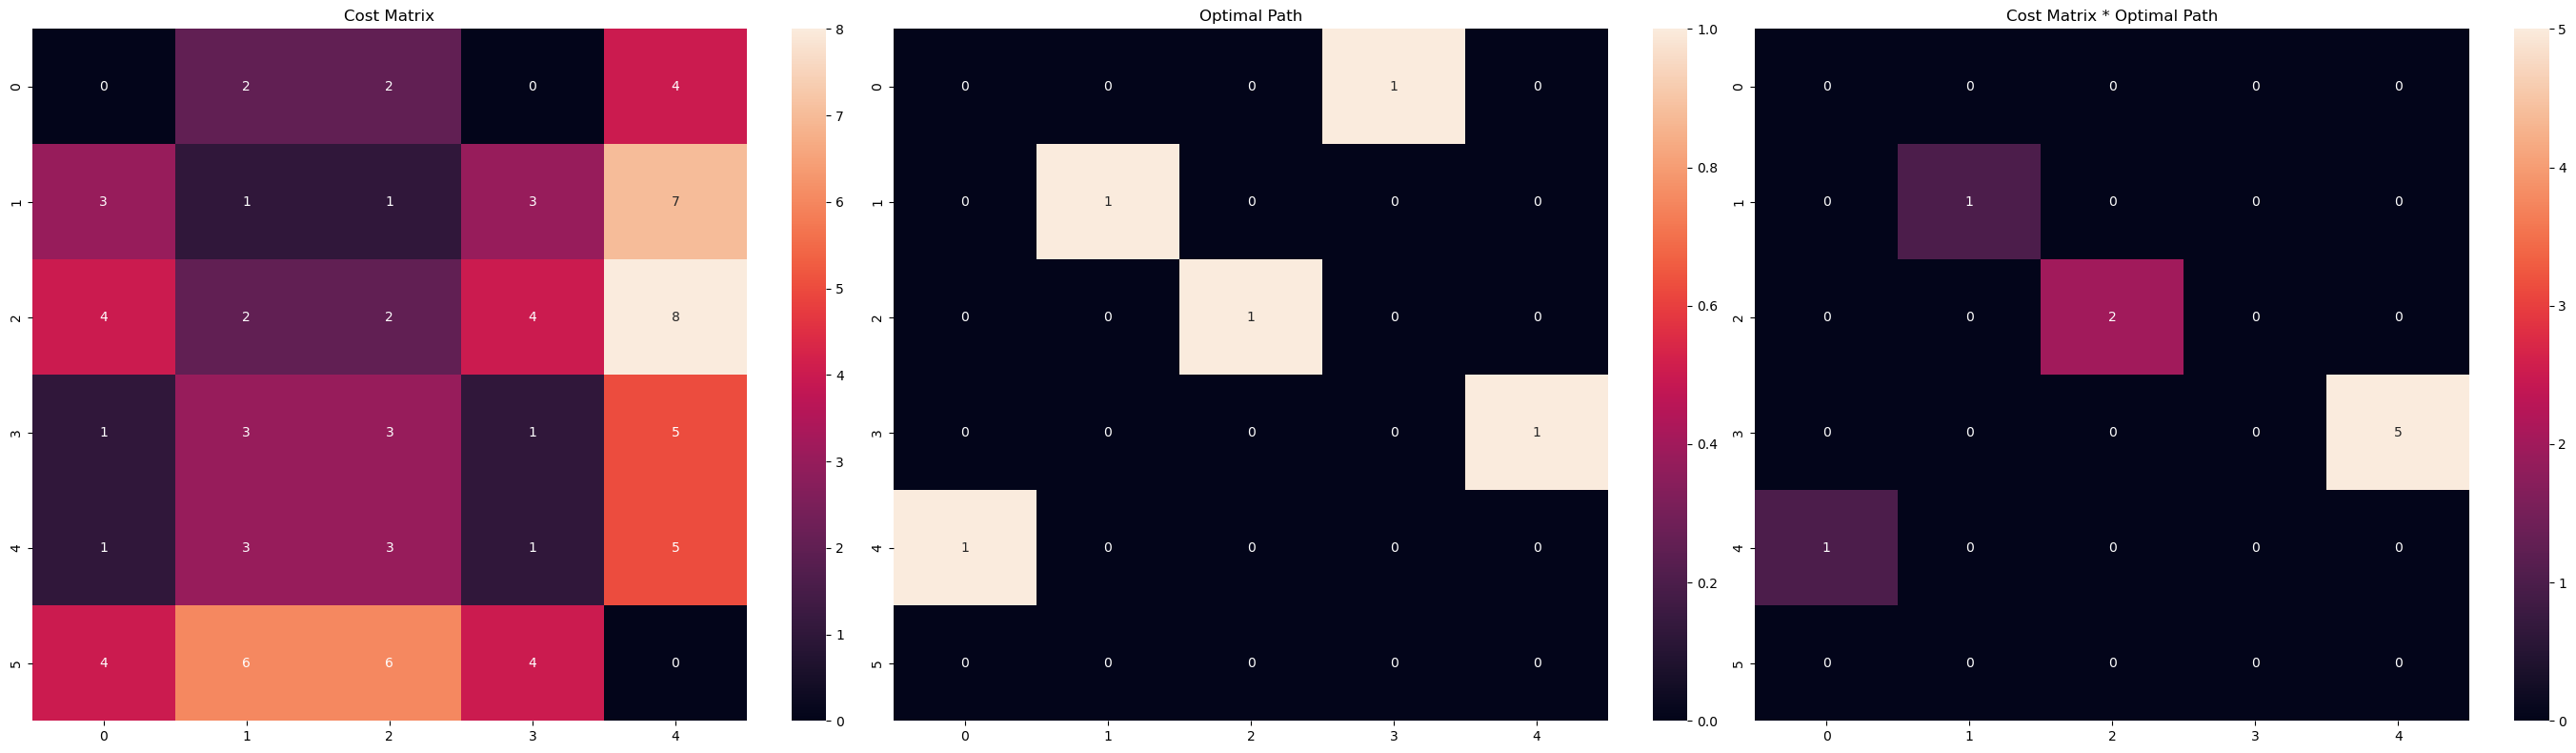

In [33]:
calculate_and_plot(d1, d2, 3)

## Sample from TUDataset

In [34]:
dataset = TUDataset('data', name='MUTAG')

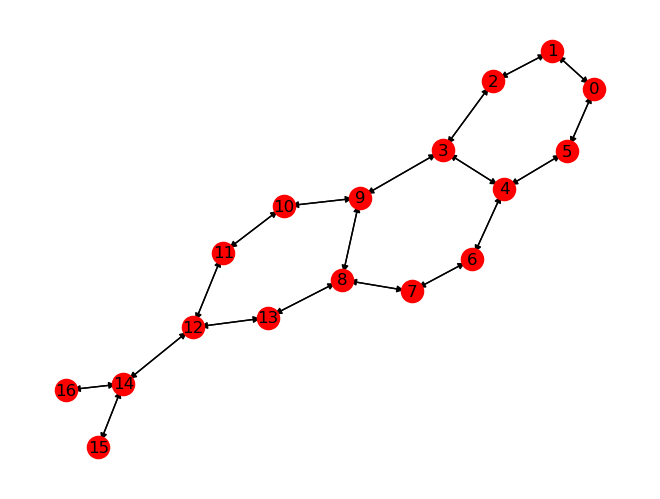

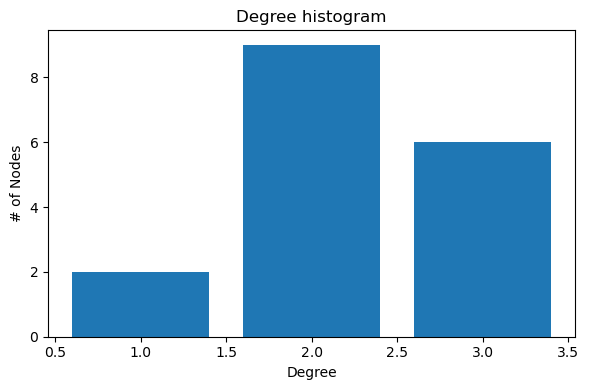

In [35]:
## Graph 1 ## 
draw_graph(dataset[0])
plot_distr_plot(dataset[0])

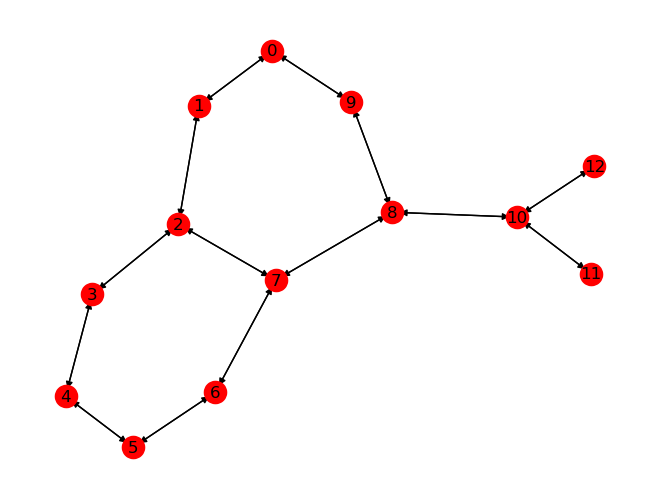

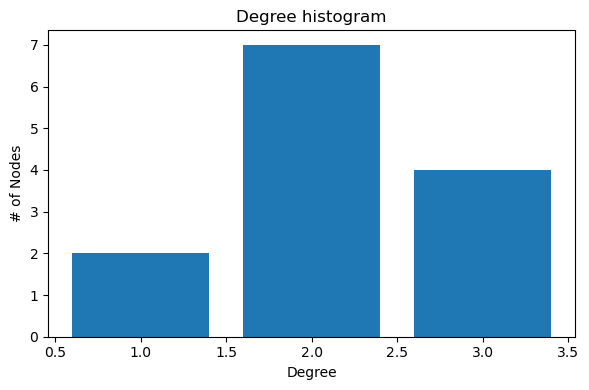

In [36]:
## Graph 2 ## 
draw_graph(dataset[1])
plot_distr_plot(dataset[1])

Layer =  2
Tree mover's distance =  14.0


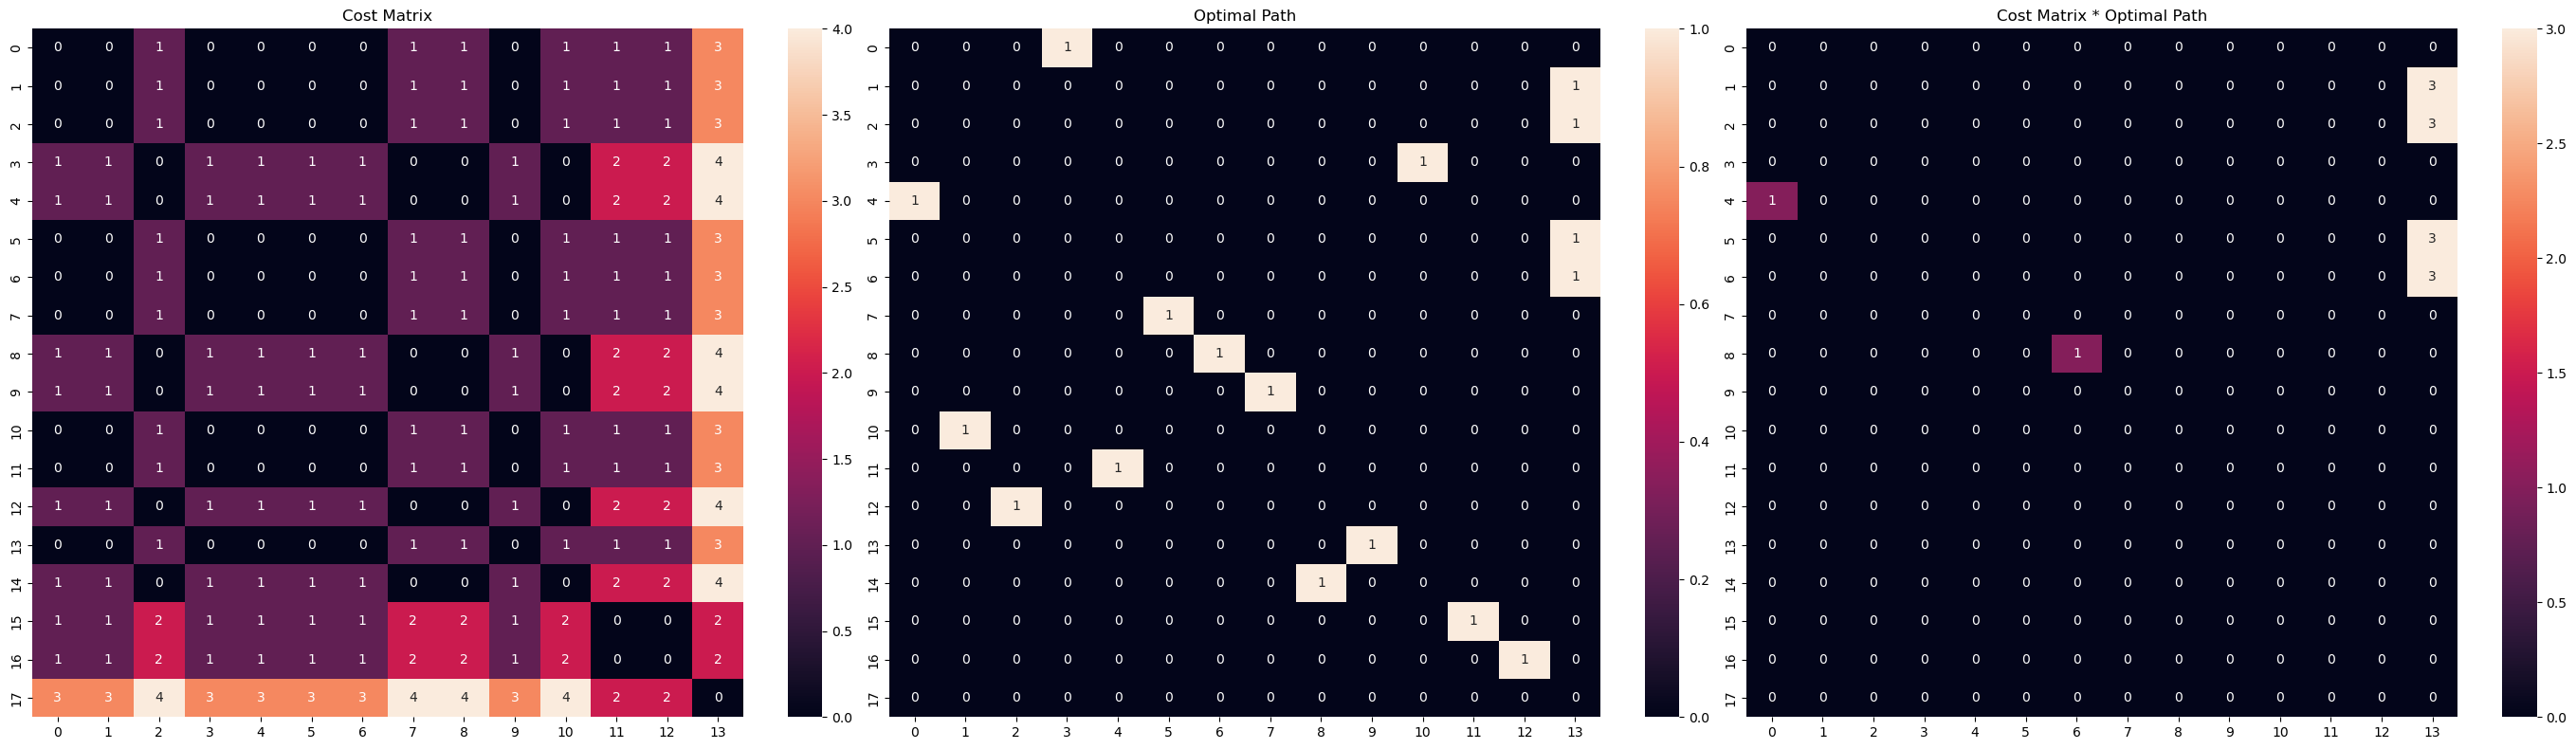

In [37]:
calculate_and_plot(dataset[0], dataset[1], 2)

Layer =  3
Tree mover's distance =  40.0


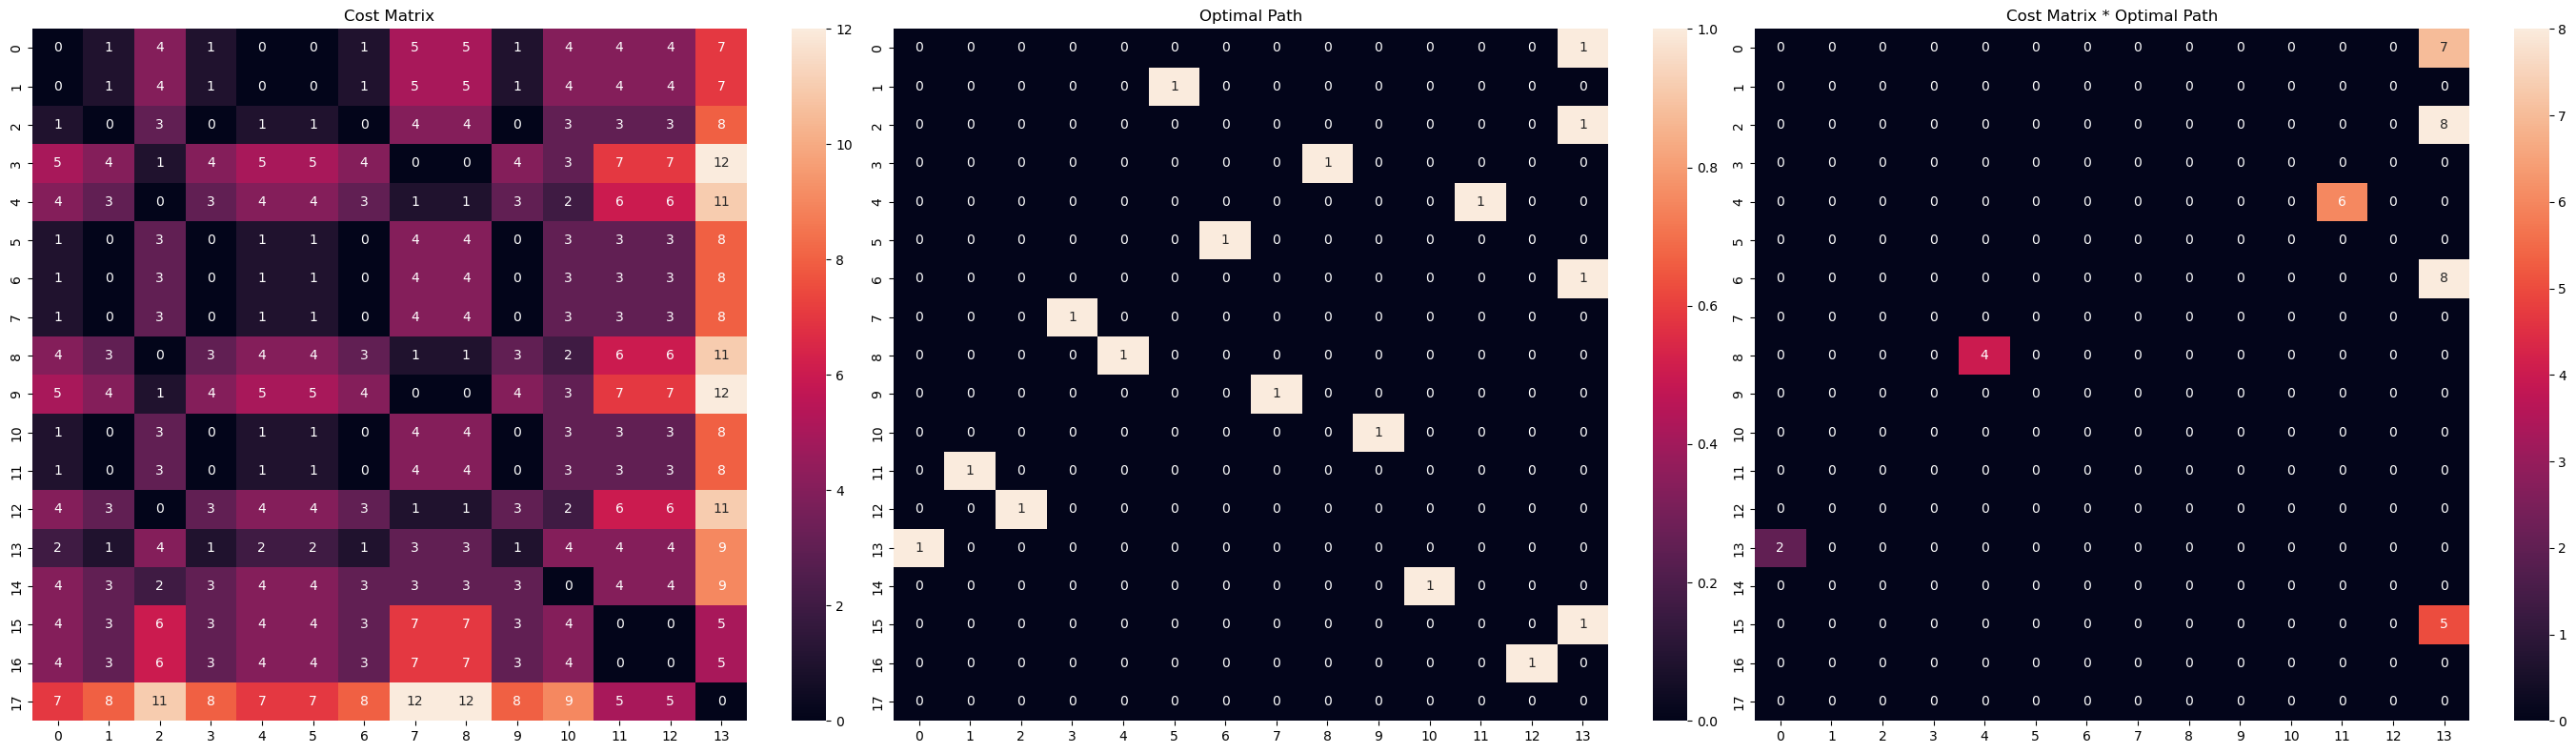

In [38]:
calculate_and_plot(dataset[0], dataset[1], 3)

Layer =  4
Tree mover's distance =  106.0


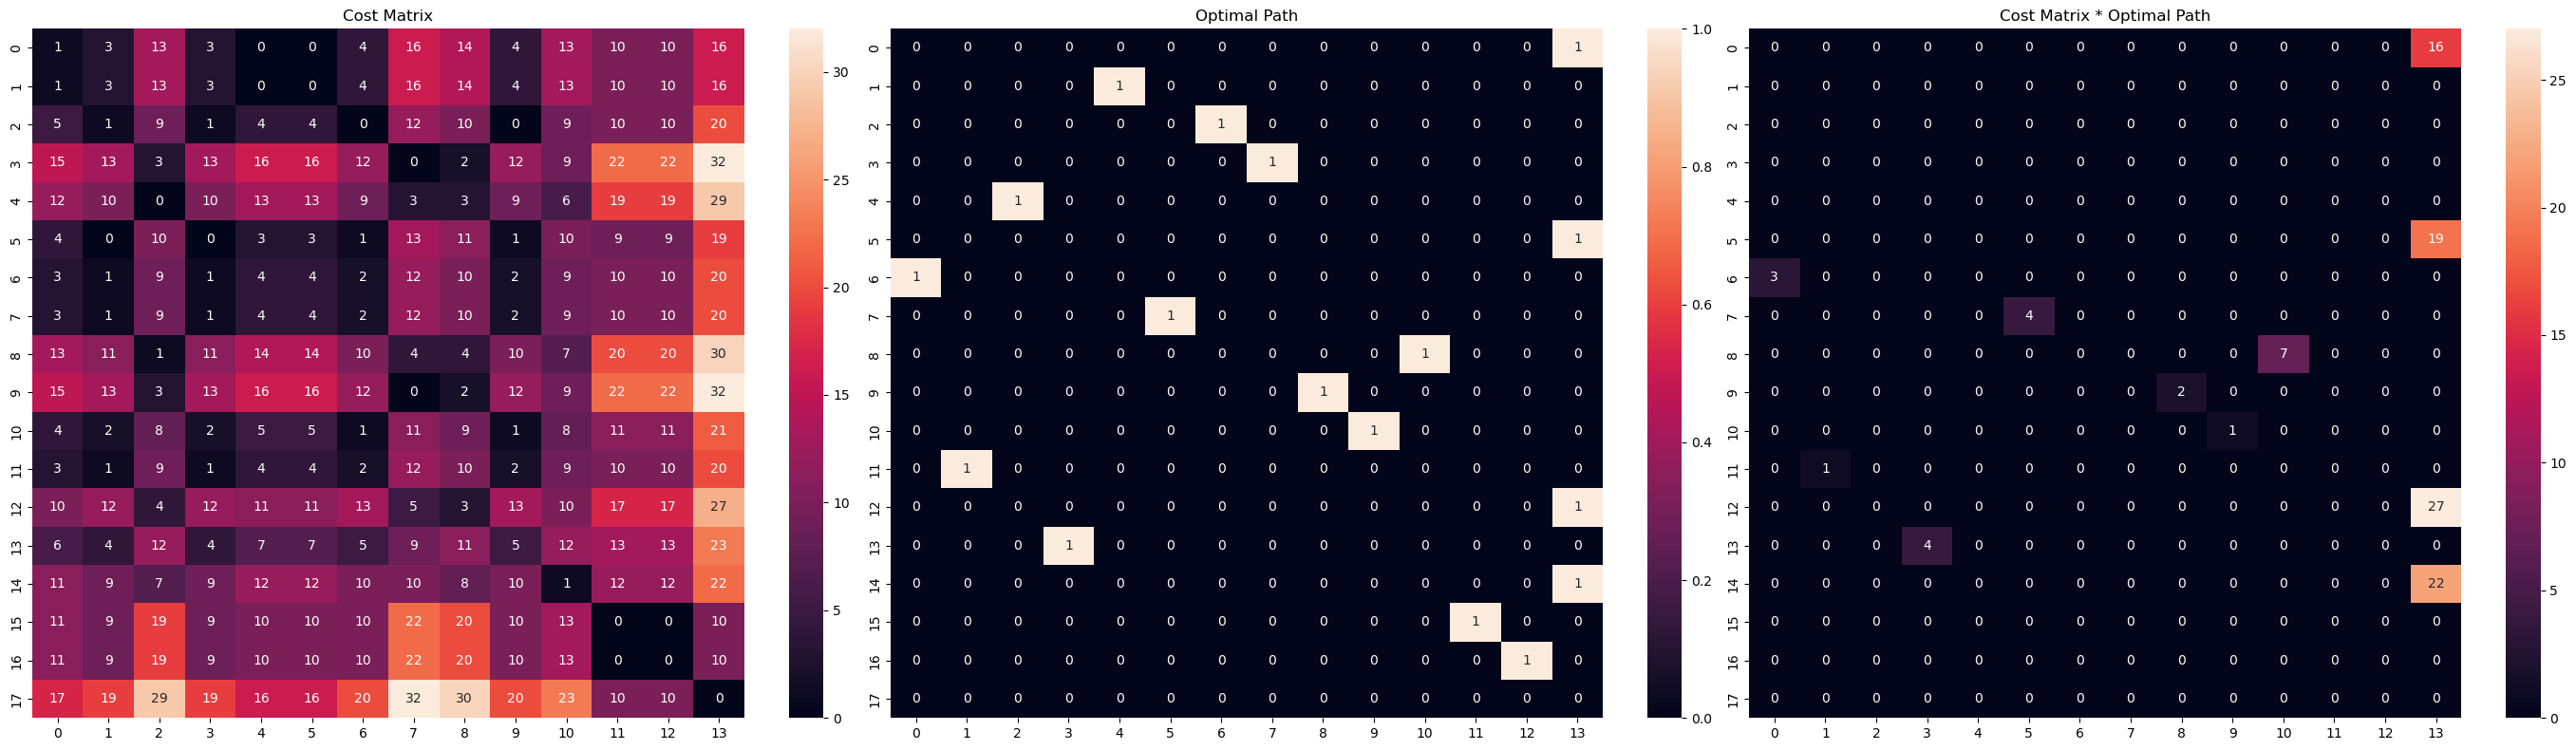

In [28]:
calculate_and_plot(dataset[0], dataset[1], 4)

# Other graphs from TUDataset

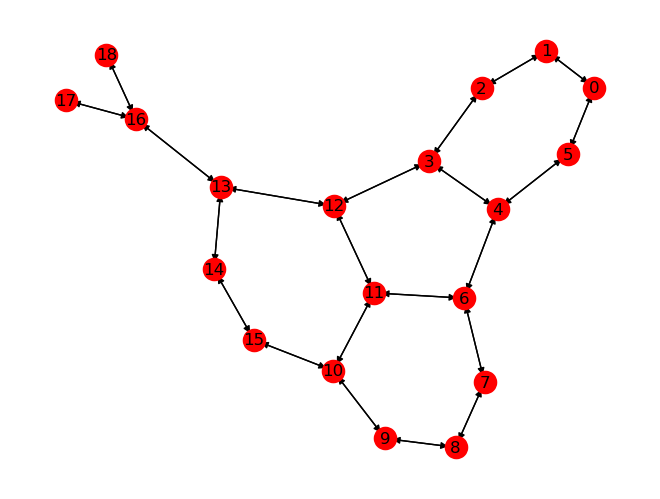

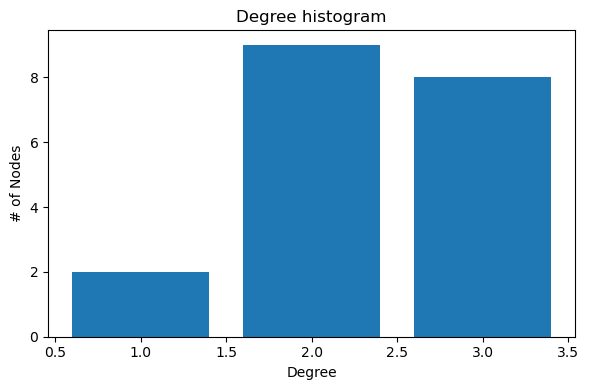

In [29]:
## Graph 1 ## 
draw_graph(dataset[3])
plot_distr_plot(dataset[3])

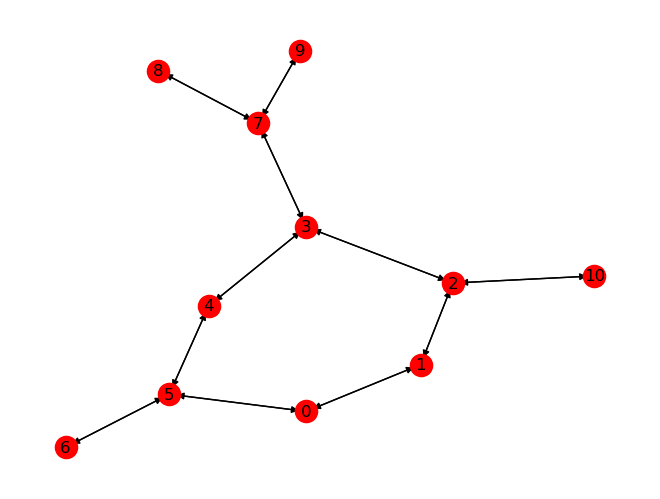

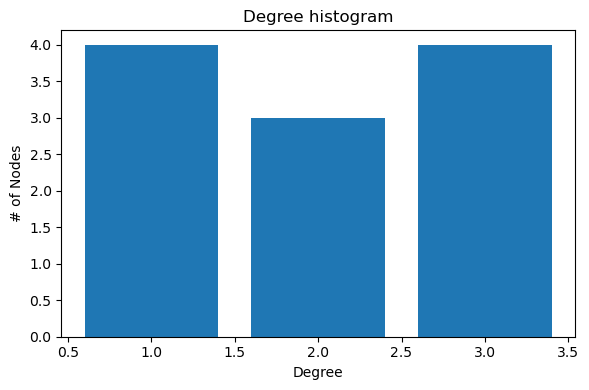

In [17]:
## Graph 2 ## 
draw_graph(dataset[4])
plot_distr_plot(dataset[4])

Layer =  2
Tree mover's distance =  30.0


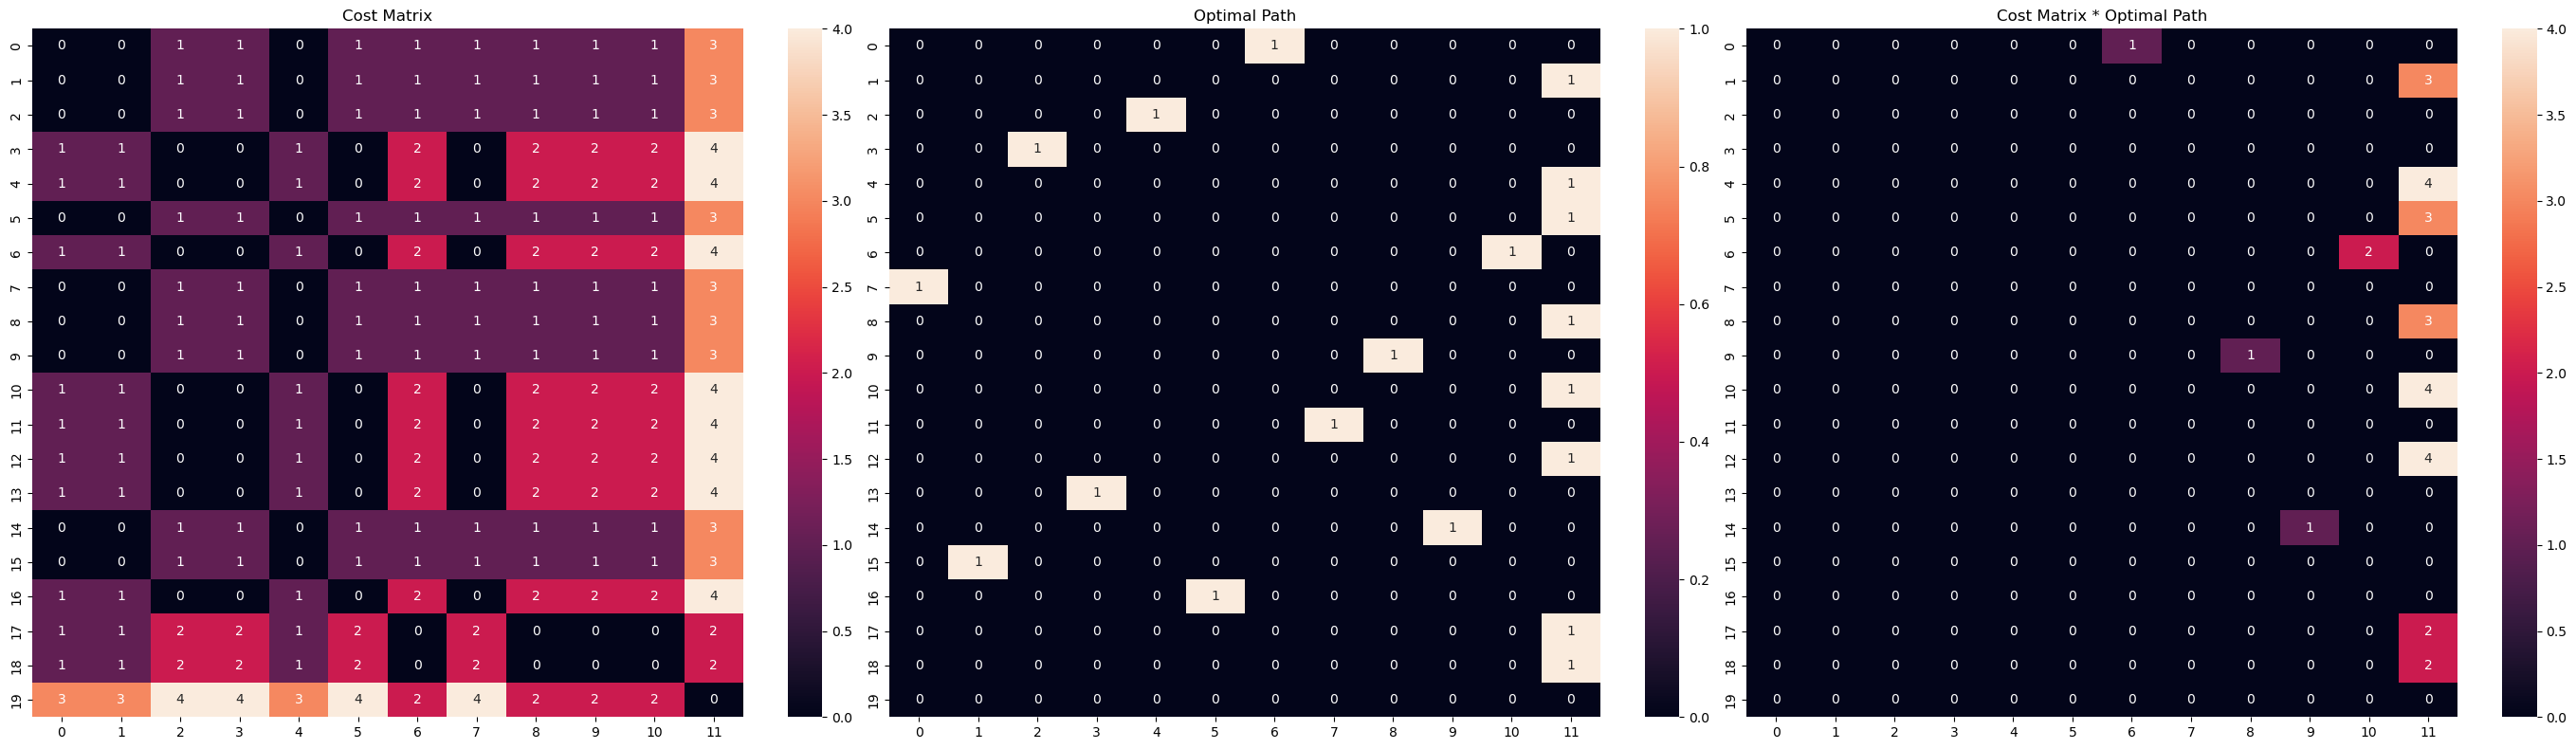

In [18]:
calculate_and_plot(dataset[3], dataset[4], 2)

Layer =  3
Tree mover's distance =  88.0


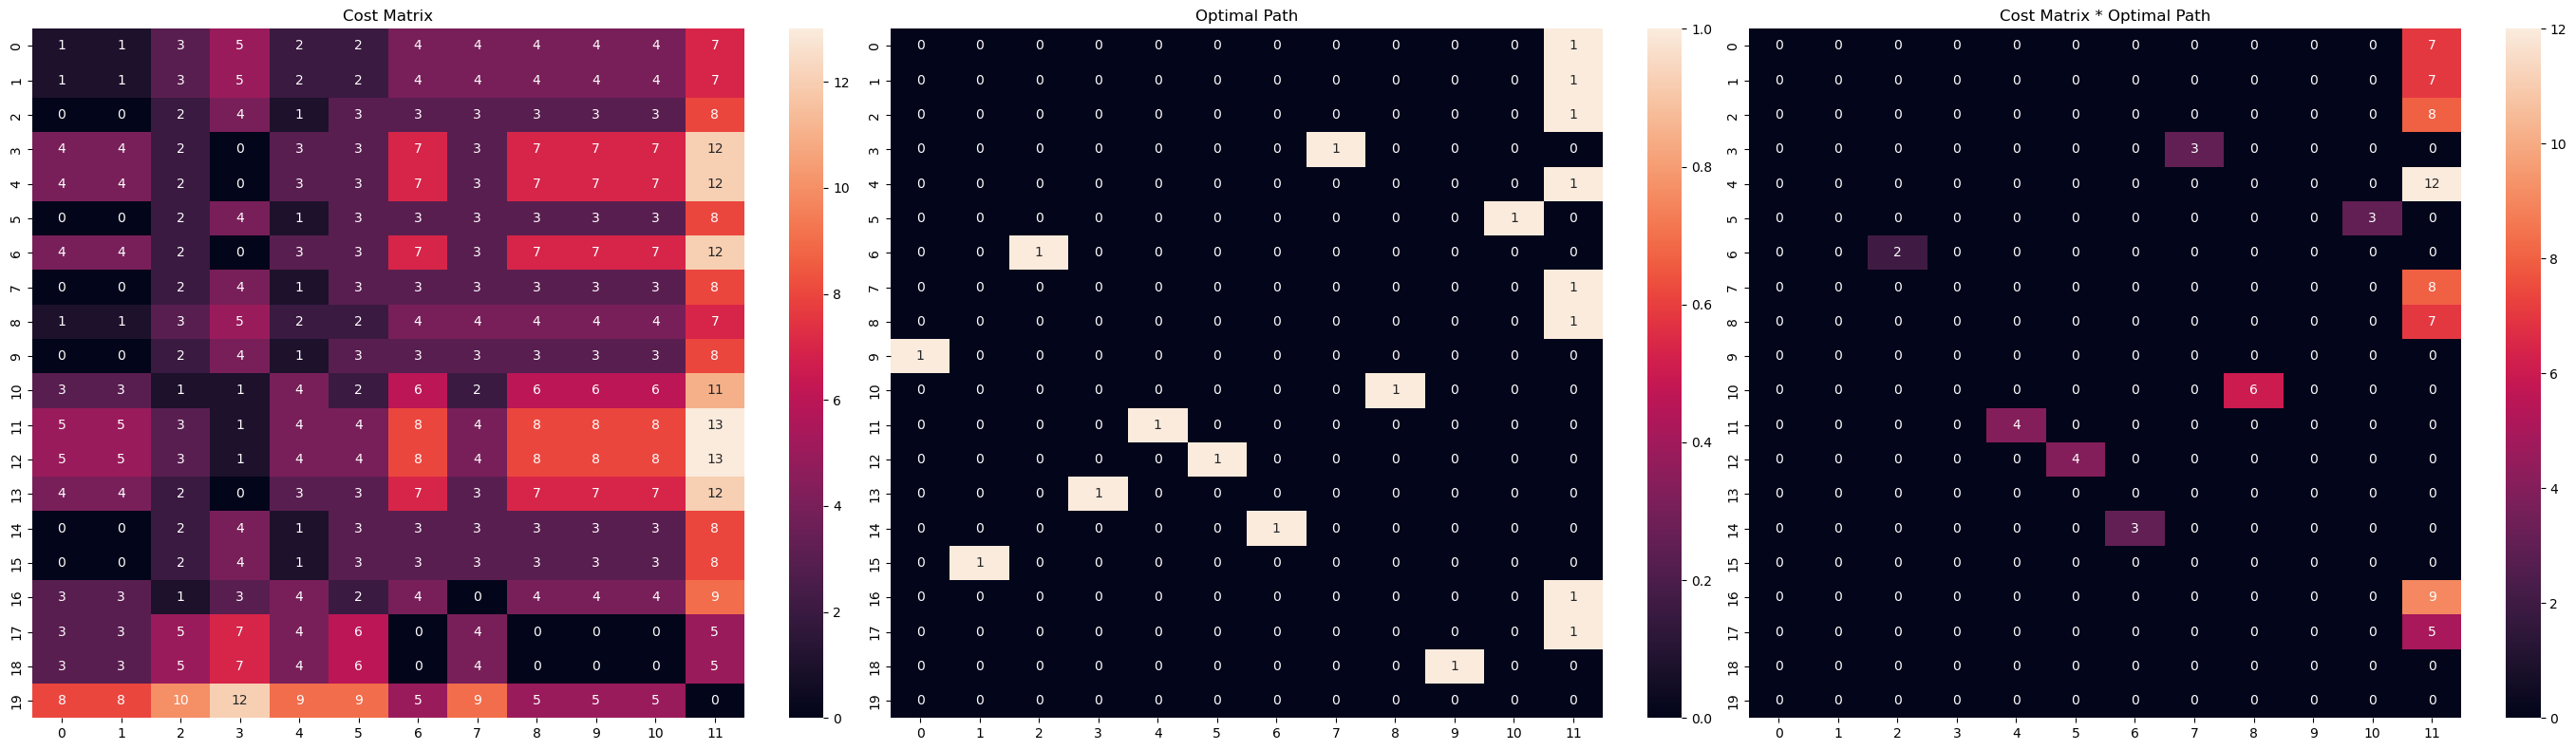

In [19]:
calculate_and_plot(dataset[3], dataset[4], 3)

Layer =  4
Tree mover's distance =  248.0


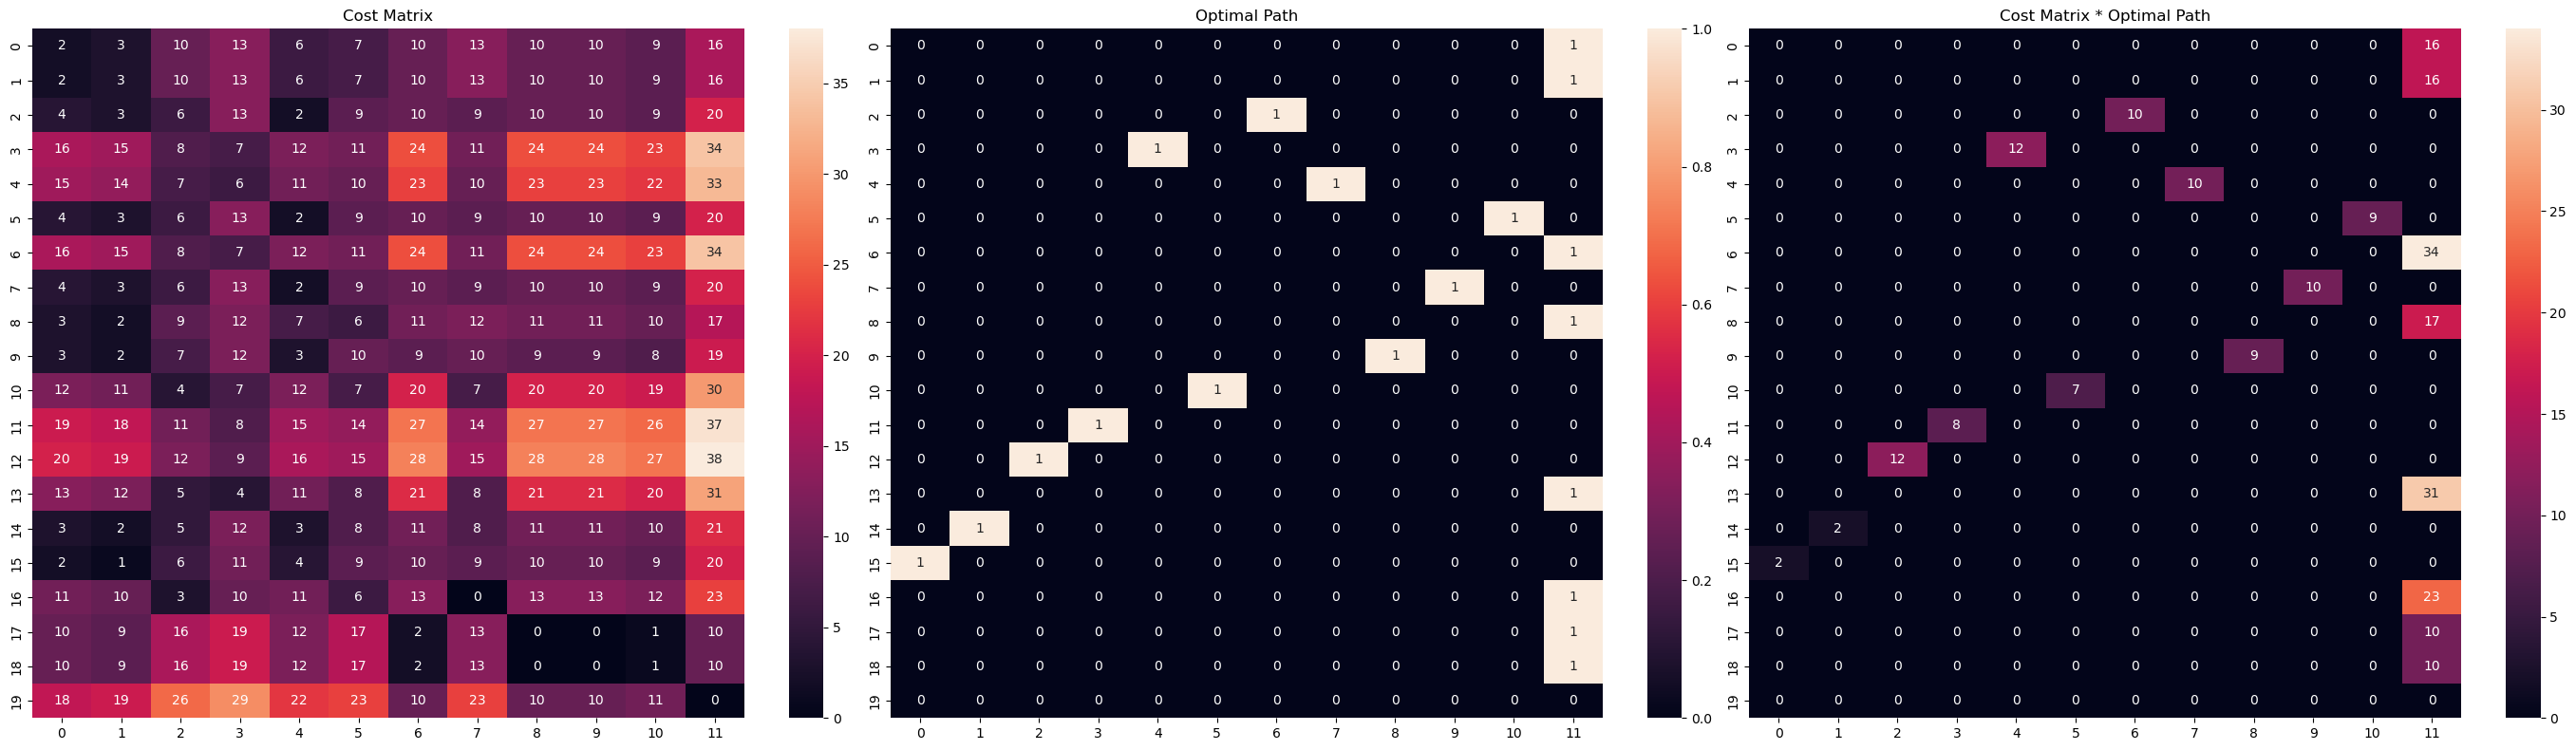

In [20]:
calculate_and_plot(dataset[3], dataset[4], 4)

In [ ]:
# jupyter nbconvert --to webpdf --allow-chromium-download Untitled.ipynb